# Fine amplitude calibration

The amplitude of a pulse can be precisely calibrated using error amplifying gate sequences. These gates sequences apply a variable number of times the same gate. Therefore, if each gate has a small error $\delta\theta$ in the rotation angle then a sequence of $n$ gates will have a rotation error of $n\cdot\delta\theta$. We will work with *ibmq_armonk* and compare our results to those reported by the backend.

In [1]:
import numpy as np

from qiskit_experiments.calibration.fine_amplitude import FineAmplitude
import qiskit.pulse as pulse

from qiskit import IBMQ

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0

In [4]:
x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit,)).instructions[0][1].pulse
x_pulse

Drag(duration=320, amp=(0.8031251817079895+0j), sigma=80, beta=-0.7400131120820395, name='Xp_d0')

In [5]:
ideal_amp = x_pulse.amp
print(f"The reported amplitude of the X pulse is {ideal_amp:.4f}.")

The reported amplitude of the X pulse is 0.8031+0.0000j.


### Detect an over-rotated pulse

We now take the x pulse reported by the backend and add a 10% overrotation to it by scaling the amplitude and see if the experiment can detect this overrotation.

In [6]:
pulse_amp = ideal_amp*1.01
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_over:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [8]:
amp_cal = FineAmplitude(qubit)
amp_cal.set_schedule(schedule=xp_over, angle_per_gate=target_angle, add_xp_circuit=True, add_sx = True)
amp_cal.set_experiment_options(add_sx=True)

Observe here that we added a square-root of X pulse before appyling the error amplifying sequence. This is done to be able to distinguish between over-rotated and under-rotated pulses.

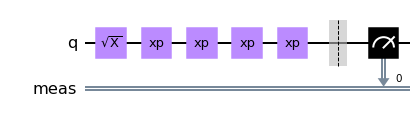

In [13]:
amp_cal.circuits(backend)[5].draw(output="mpl")

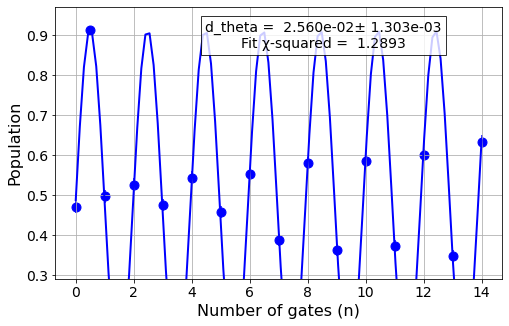

In [14]:
data_over = amp_cal.run(backend)

In [15]:
result = data_over.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.85069805,  0.02560132,  0.48773587]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.01931795, 0.0013029 , 0.00397166]),
 'pcov': array([[3.73183095e-04, 1.11303140e-05, 3.15858216e-05],
        [1.11303140e-05, 1.69754133e-06, 7.71869272e-07],
        [3.15858216e-05, 7.71869272e-07, 1.57740892e-05]]),
 'reduced_chisq': 1.289254524650247,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [16]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of 0.026 rad.
Thus, scale the 0.8112+0.0000j pulse amplitude by 0.992 to obtain 0.80460+0.00000j.
Amplitude reported by the backend 0.8031+0.0000j.


### Detect an under-rotated pulse

In [17]:
pulse_amp = ideal_amp*0.99
target_angle = np.pi

with pulse.build(backend=backend, name="xp") as xp_under:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [19]:
amp_cal = FineAmplitude(qubit)
amp_cal.set_schedule(schedule=xp_under, angle_per_gate=target_angle, add_xp_circuit=True, add_sx=True)
amp_cal.set_experiment_options(add_sx=True)

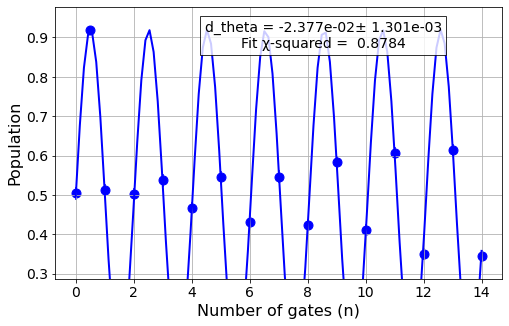

In [20]:
data_under = amp_cal.run(backend)

In [21]:
result = data_under.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.8471443 , -0.02376535,  0.49643322]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.01873673, 0.00130128, 0.00398428]),
 'pcov': array([[ 3.51065124e-04, -1.06965679e-05,  3.17136995e-05],
        [-1.06965679e-05,  1.69332571e-06, -1.21863565e-06],
        [ 3.17136995e-05, -1.21863565e-06,  1.58744635e-05]]),
 'reduced_chisq': 0.8784058423778185,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [22]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {ideal_amp:.4f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.024 rad.
Thus, scale the 0.7951+0.0000j pulse amplitude by 1.008 to obtain 0.80115+0.00000j.
Amplitude reported by the backend 0.8031+0.0000j.


### Analyze a pi-half pulse

We now consider the pi-half rotation. Note that in this case we do not need to add a pi-half rotation to the circuits.

In [23]:
pulse_amp = ideal_amp / 2
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [25]:
amp_cal.set_schedule(schedule=x90p, angle_per_gate=target_angle, add_xp_circuit=True, add_sx=False)

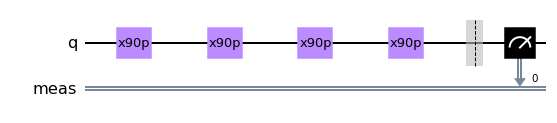

In [26]:
amp_cal.circuits(backend)[5].draw(output="mpl")

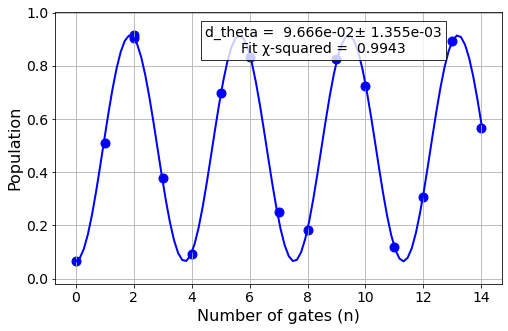

In [27]:
data_x90p = amp_cal.run(backend)

In [28]:
result = data_x90p.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.84976484,  0.09665677,  0.48962715]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.00677521, 0.00135457, 0.00279164]),
 'pcov': array([[4.59034429e-05, 3.41371521e-07, 8.79893734e-07],
        [3.41371521e-07, 1.83486272e-06, 5.46769211e-08],
        [8.79893734e-07, 5.46769211e-08, 7.79325532e-06]]),
 'reduced_chisq': 0.9942504561572814,
 'dof': 13,
 'xrange': [0.0, 14.0],
 'quality': 'computer_good',
 'success': True}

In [29]:
sx = backend.defaults().instruction_schedule_map.get('sx', (qubit,))
sx_ideal_amp = sx.instructions[0][1].pulse.amp

dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.097 rad.
Thus, scale the 0.4016+0.0000j pulse amplitude by 0.942 to obtain 0.37829+0.00000j.
Amplitude reported by the backend 0.3696-0.0760j.


Let's rerun this calibration using the updated value of the amplitude of the pi-half pulse and run under slightly different settings. We will run only points on the equator of the Bloch sphere except for the first three pi-half pulses.

In [30]:
pulse_amp = ideal_amp / 2 * scale
target_angle = np.pi / 2

with pulse.build(backend=backend, name="x90p") as x90p:
    pulse.play(
        pulse.Drag(
            duration=x_pulse.duration, amp=pulse_amp, sigma=x_pulse.sigma, beta=x_pulse.beta
        ), 
        pulse.drive_channel(qubit)
    )

In [32]:
repetitions = [1, 2, 3] + list(range(5,21,2))
amp_cal.set_schedule(schedule=x90p, angle_per_gate=target_angle, add_xp_circuit=False, add_sx=False)
amp_cal.set_experiment_options(repetitions=repetitions)

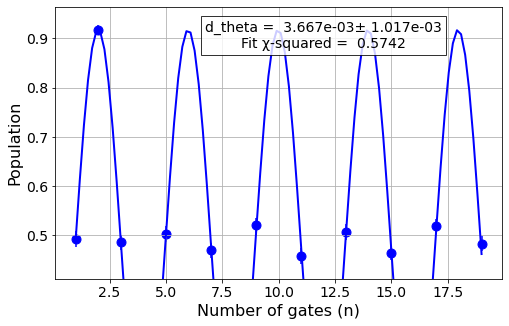

In [33]:
data_x90p = amp_cal.run(backend)

In [34]:
result = data_x90p.analysis_result(-1)
result

{'analysis_type': 'FineAmplitudeAnalysis',
 'popt': array([-0.85200496,  0.00366679,  0.4919772 ]),
 'popt_keys': ['amp', 'd_theta', 'baseline'],
 'popt_err': array([0.01980687, 0.00101734, 0.00495499]),
 'pcov': array([[3.92312074e-04, 2.55640719e-06, 4.90966240e-05],
        [2.55640719e-06, 1.03497599e-06, 6.51013366e-07],
        [4.90966240e-05, 6.51013366e-07, 2.45519114e-05]]),
 'reduced_chisq': 0.5742055254291218,
 'dof': 8,
 'xrange': [1.0, 19.0],
 'quality': 'computer_good',
 'success': True}

In [35]:
dtheta = result["popt"][1]
scale = target_angle / (target_angle + dtheta)
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")
print(f"Amplitude reported by the backend {sx_ideal_amp:.4f}.")

The ideal angle is 1.57 rad. We measured a deviation of 0.004 rad.
Thus, scale the 0.3783+0.0000j pulse amplitude by 0.998 to obtain 0.37740+0.00000j.
Amplitude reported by the backend 0.3696-0.0760j.
